In [1]:
using Pkg;
Pkg.activate("../");

using PyCall;
pygui(:tk);

  Activating project at `D:\GitHub\book-dp1`

In [2]:
using Distributions, IterTools, QuantEcon

function create_inventory_model(; S=100,  # Order size
                                  s=10,   # Order threshold
                                  p=0.4)  # Demand parameter
    ϕ = Geometric(p)
    h(x, d) = max(x - d, 0) + S*(x <= s)
    return (; S, s, p, ϕ, h)
end

"Simulate the inventory process."
function sim_inventories(model; ts_length=200)
    (; S, s, p, ϕ, h) = model
    X = Vector{Int32}(undef, ts_length)
    X[1] = S  # Initial condition
    for t in 1:(ts_length-1)
        X[t+1] = h(X[t], rand(ϕ))
    end
    return X
end

"Compute the transition probabilities and state."
function compute_mc(model; d_max=100)
    (; S, s, p, ϕ, h) = model
    n = S + s + 1  # Size of state space
    state_vals = collect(0:(S + s))
    P = Matrix{Float64}(undef, n, n)
    for (i, j) in product(1:n, 1:n)
        P[i, j] = sum((h(i-1, d) == j-1)*pdf(ϕ, d) for d in 0:d_max)
    end
    return MarkovChain(P, state_vals)
end

"Compute the stationary distribution of the model."
function compute_stationary_dist(model)
    mc = compute_mc(model)
    return mc.state_values, stationary_distributions(mc)[1]
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering


function plot_ts(model; fontsize=16, 
                   figname="../figures/inventory_sim_1.pdf",
                   savefig=false)
    (; S, s, p, ϕ, h) = model
    X = sim_inventories(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(X, label=L"X_t", lw=3, alpha=0.6)
    ax.set_xlabel(L"t", fontsize=fontsize)
    ax.set_ylabel("inventory", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylim(0, S + s + 20)

    plt.show()
    if savefig == true
        fig.savefig(figname)
    end
end


function plot_hist(model; fontsize=16, 
                   figname="../figures/inventory_sim_2.pdf",
                   savefig=false)
    (; S, s, p, ϕ, h) = model
    state_values, ψ_star = compute_stationary_dist(model) 
    X = sim_inventories(model; ts_length=1_000_000)
    histogram = [mean(X .== i) for i in state_values]

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(state_values, ψ_star, "k-",  lw=3, alpha=0.7, label=L"\psi^*")
    ax.bar(state_values, histogram, alpha=0.7, label="frequency")
    ax.set_xlabel("state", fontsize=fontsize)

    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylim(0, 0.015)

    plt.show()
    if savefig == true
        fig.savefig(figname)
    end
end


plot_hist (generic function with 1 method)

In [3]:
model = create_inventory_model()

(S = 100, s = 10, p = 0.4, ϕ = Geometric{Float64}(p=0.4), h = var"#h#4"{Int64, Int64}(100, 10))

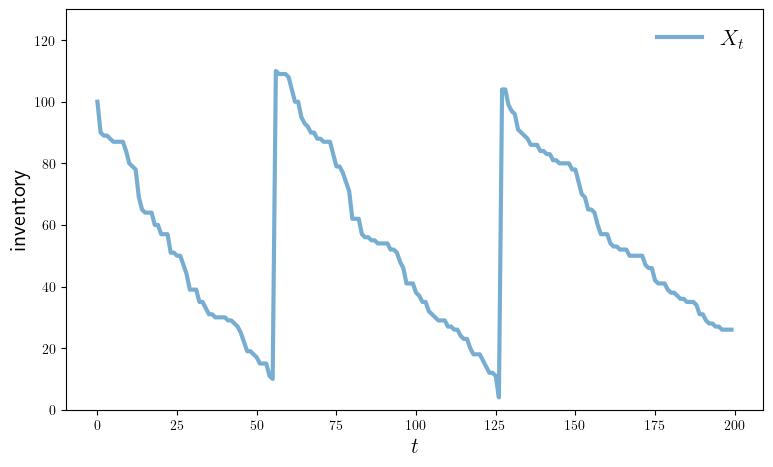

In [4]:
plot_ts(model; savefig=true)

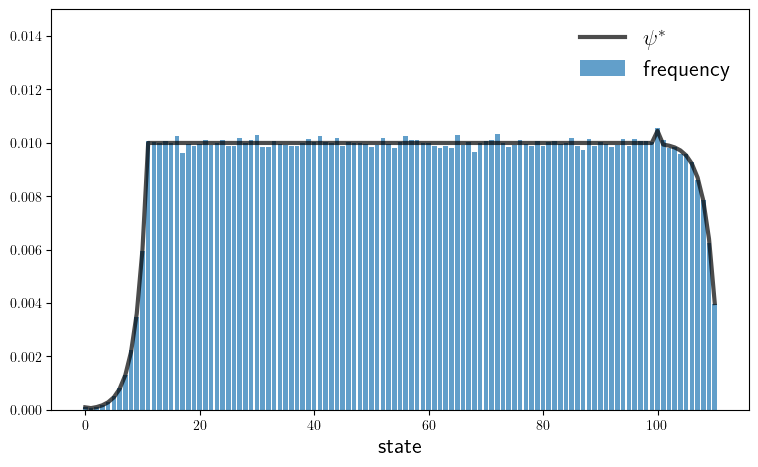

In [5]:
plot_hist(model; savefig=true)

In [6]:
using QuantEcon
P = [0.1 0.9;
     0.0 1.0]
mc = MarkovChain(P)
print(is_irreducible(mc))

false

In [7]:
function create_laborer_model(; α=0.3, β=0.2)
    return (; α, β)
end

function laborer_update(x, model)  # update X from t to t+1
    (; α, β) = model
    if x == 1    
        x′ = rand() < α ? 2 : 1
    else 
        x′ = rand() < β ? 1 : 2
    end
    return x′
end

function sim_chain(k, p, model)
    X = Array{Int32}(undef, k)
    X[1] = rand() < p ? 1 : 2
    for t in 1:(k-1)
        X[t+1] = laborer_update(X[t], model)
    end
    return X
end

function test_convergence(; k=10_000_000, p=0.5)
    model = create_laborer_model()
    (; α, β) = model
    ψ_star = (1/(α + β)) * [β α]

    X = sim_chain(k, p, model)
    ψ_e = (1/k) * [sum(X .== 1)  sum(X .== 2)]
    error = maximum(abs.(ψ_star - ψ_e))
    approx_equal = isapprox(ψ_star, ψ_e, rtol=0.01)
    println("Sup norm deviation is $error")
    println("Approximate equality is $approx_equal")
 end


test_convergence (generic function with 1 method)

In [8]:
"""
Infinite-horizon job search with Markov wage draws.

"""

using QuantEcon, LinearAlgebra
include("s_approx.jl")

"Creates an instance of the job search model with Markov wages."
function create_markov_js_model(;
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0        # unemployment compensation
    )
    mc = tauchen(n, ρ, ν)
    w_vals, P = exp.(mc.state_values), mc.p
    return (; n, w_vals, P, β, c)
end

" The Bellman operator Tv = max{e, c + β P v} with e(w) = w / (1-β)."
function T(v, model)
    (; n, w_vals, P, β, c) = model
    h = c .+ β * P * v
    e = w_vals ./ (1 - β)
    return max.(e, h)
end

" Get a v-greedy policy."
function get_greedy(v, model)
    (; n, w_vals, P, β, c) = model
    σ = w_vals / (1 - β) .>= c .+ β * P * v
    return σ
end

"Solve the infinite-horizon Markov job search model by VFI."
function vfi(model) 
    v_init = zero(model.w_vals)  
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end

        

# == Policy iteration == #

"Get the value of policy σ."
function get_value(σ, model)
    (; n, w_vals, P, β, c) = model
    e = w_vals ./ (1 - β)
    K_σ = β .* (1 .- σ) .* P
    r_σ = σ .* e .+ (1 .- σ) .* c
    return (I - K_σ) \ r_σ
end


    
"Howard policy iteration routine."
function policy_iteration(model)
    σ = Vector{Bool}(undef, model.n)
    i, error = 0, 1.0
    while error > 0
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = maximum(abs.(σ_new - σ))
        σ = σ_new
        i = i + 1
        println("Concluded loop $i with error $error.")
    end
    return σ
end


# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

default_model = create_markov_js_model()


function plot_main(; model=default_model,
                     method="vfi", 
                     savefig=false, 
                     figname="../figures/markov_js_1.pdf")
    (; n, w_vals, P, β, c) = model


    if method == "vfi"
        v_star, σ_star = vfi(model)
    else
        σ_star = policy_iteration(model)
        v_star = get_value(σ_star, model)
    end

    h_star = c .+ β * P * v_star
    e = w_vals / (1 - β)

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_vals, h_star, lw=4, ls="--", alpha=0.4, label=L"h^*(w)")
    ax.plot(w_vals, e, lw=4, ls="--", alpha=0.4, label=L"w/(1-\beta)")
    ax.plot(w_vals, max.(e, h_star), "k-", alpha=0.7, label=L"v^*(w)")
    ax.legend(frameon=false, fontsize=fontsize)
    ax.set_xlabel(L"w", fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig(figname)
    end
end

LoadError: SystemError: opening file "D:\\GitHub\\book-dp1\\juliabook\\s_approx.jl": No such file or directory

In [9]:
plot_main(savefig=true)

LoadError: UndefVarError: `plot_main` not defined

In [10]:
"""
Infinite-horizon job search with Markov wage draws and separation.

"""

include("s_approx.jl")
using QuantEcon, LinearAlgebra

"Creates an instance of the job search model with separation."
function create_js_with_sep_model(;
        n=200,          # wage grid size
        ρ=0.9, ν=0.2,   # wage persistence and volatility
        β=0.98, α=0.1,  # discount factor and separation rate
        c=1.0)          # unemployment compensation
    mc = tauchen(n, ρ, ν)
    w_vals, P = exp.(mc.state_values), mc.p
    return (; n, w_vals, P, β, c, α)
end

" The Bellman operator for the value of being unemployed."
function T(v, model)
    (; n, w_vals, P, β, c, α) = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * P * v)
    reject = c .+ β * P * v
    return max.(accept, reject)
end

" Get a v-greedy policy."
function get_greedy(v, model)
    (; n, w_vals, P, β, c, α) = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * P * v)
    reject = c .+ β * P * v
    σ = accept .>= reject
    return σ
end

"Solve by VFI."
function vfi(model) 
    v_init = zero(model.w_vals)  
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end


# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

default_model = create_js_with_sep_model()


function plot_main(; model=default_model,
                     method="vfi", 
                     savefig=false, 
                     figname="../figures/markov_js_with_sep_1.pdf")
    (; n, w_vals, P, β, c, α) = model
    v_star, σ_star = vfi(model)

    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * P * v_star)
    h_star = c .+ β * P * v_star

    w_star = Inf
    for (i, w) in enumerate(w_vals)
        if accept[i] ≥ h_star[i]
            w_star = w
            break
        end
    end
    @assert w_star < Inf "Agent never accepts"

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_vals, h_star, lw=4, ls="--", alpha=0.4, label="continuation value")
    ax.plot(w_vals, accept, lw=4, ls="--", alpha=0.4, label="stopping value")
    ax.plot(w_vals, v_star, "k-", alpha=0.7, label=L"v_u^*(w)")
    ax.legend(frameon=false, fontsize=fontsize)
    ax.set_xlabel(L"w", fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig(figname)
    end
end

function plot_w_stars(; α_vals=LinRange(0.0, 1.0, 10),
                        savefig=false, 
                        figname="../figures/markov_js_with_sep_2.pdf")

    w_star_vec = similar(α_vals)
    for (i_α, α) in enumerate(α_vals)
        print(i_α, α)
        model = create_js_with_sep_model(α=α)
        (; n, w_vals, P, β, c, α) = model
        v_star, σ_star = vfi(model)

        d = 1 / (1 - β * (1 - α))
        accept = d * (w_vals + α * β * P * v_star)
        h_star = c .+ β * P * v_star

        w_star = Inf
        for (i_w, w) in enumerate(w_vals)
            if accept[i_w] ≥ h_star[i_w]
                w_star = w
                break
            end
        end
        @assert w_star < Inf "Agent never accepts"
        w_star_vec[i_α] = w_star
    end

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(α_vals, w_star_vec, lw=2, alpha=0.6, label="reservation wage")
    ax.legend(frameon=false, fontsize=fontsize)
    ax.set_xlabel(L"\alpha", fontsize=fontsize)
    ax.set_xlabel(L"w", fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig(figname)
    end
end

LoadError: SystemError: opening file "D:\\GitHub\\book-dp1\\juliabook\\s_approx.jl": No such file or directory

In [11]:
plot_main(savefig=true)

LoadError: UndefVarError: `plot_main` not defined

In [12]:
plot_w_stars(savefig=true)

LoadError: UndefVarError: `plot_w_stars` not defined